<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-END-Program/blob/main/09-%20HandsOn%203/openBookQA/openBookQA_Learning_Phrase_Repr_RNN_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# openBookQA dataset - RNN Seq2Seq Encoder Decoder solution with Learning Phrase Representation

openBookQA

Dataset contains questions set for 1329 elementary level scientific facts. There are about 6000 questions focused on these facts.

Files

OpenBookQA-V1-Sep2018\Data\Main folder contains train, test and dev(valid) json files. These files contain question column. Question further contains stem question and 4 answer choices for them. The correct answer from the answer choice is given in answerKey.

File required - train.jsonl, test.jsonl and dev.jsonl

Learnings-

1. The decoder takes the context vector (generated from encoder) along with embedded input token and previous hidden state to predict hidden state (s_t)
2. The context vector is fed to the linear layer along with hidden output to predict the next token.

3. Train, test and val split was done as per the set division provided in the dataset. Train, test, val splits do not share documents. Hence, their information is not leaked. Test loss observed = 4.381 (Perplexity score=79.880)

### Additional packages

In [ ]:
# Packages
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Load Dataset

In [ ]:
OPENBOOKQA_DATA_URL="https://s3-us-west-2.amazonaws.com/ai2-website/data/OpenBookQA-V1-Sep2018.zip"
!wget $OPENBOOKQA_DATA_URL
!unzip $(basename $OPENBOOKQA_DATA_URL)

--2021-01-04 14:00:19--  https://s3-us-west-2.amazonaws.com/ai2-website/data/OpenBookQA-V1-Sep2018.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.221.224
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.221.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1446098 (1.4M) [application/zip]
Saving to: ‘OpenBookQA-V1-Sep2018.zip’

OpenBookQA-V1-Sep20 100%[===================>]   1.38M  2.87MB/s    in 0.5s    

2021-01-04 14:00:19 (2.87 MB/s) - ‘OpenBookQA-V1-Sep2018.zip’ saved [1446098/1446098]

Archive:  OpenBookQA-V1-Sep2018.zip
   creating: OpenBookQA-V1-Sep2018/
   creating: OpenBookQA-V1-Sep2018/Data/
   creating: OpenBookQA-V1-Sep2018/Data/Additional/
  inflating: OpenBookQA-V1-Sep2018/Data/Additional/test_complete.jsonl  
  inflating: OpenBookQA-V1-Sep2018/Data/Additional/train_complete.jsonl  
  inflating: OpenBookQA-V1-Sep2018/Data/Additional/crowdsourced-facts.txt  
  inflating: OpenBookQA-V

Below are the steps to extract stem and correct choice text column from the json file. Step by step process is done for train set. We'll create a function with these steps to extract for test and valid dataset.

In [ ]:
df_openBookQA = pd.read_json(path_or_buf='/content/OpenBookQA-V1-Sep2018/Data/Main/train.jsonl', lines=True)
print(df_openBookQA.shape)
df_openBookQA.head()

(4957, 3)


,id,question,answerKey
0,7-980,"{'stem': 'The sun is responsible for', 'choice...",D
1,7-584,{'stem': 'When standing miles away from Mount ...,D
2,7-870,{'stem': 'When food is reduced in the stomach'...,C
3,7-321,"{'stem': 'Stars are', 'choices': [{'text': 'wa...",C
4,9-732,"{'stem': 'You can make a telescope with a', 'c...",D


Extract stem and choices from question columns by pd.normalize

In [ ]:
# pd_all = pd.json_normalize(df_openBookQA.question)
df_openBookQA = df_openBookQA.join(pd.json_normalize(df_openBookQA.question))
print(df_openBookQA.shape)
df_openBookQA.head()

(4957, 5)


,id,question,answerKey,stem,choices
0,7-980,"{'stem': 'The sun is responsible for', 'choice...",D,The sun is responsible for,"[{'text': 'puppies learning new tricks', 'labe..."
1,7-584,{'stem': 'When standing miles away from Mount ...,D,When standing miles away from Mount Rushmore,"[{'text': 'the mountains seem very close', 'la..."
2,7-870,{'stem': 'When food is reduced in the stomach'...,C,When food is reduced in the stomach,"[{'text': 'the mind needs time to digest', 'la..."
3,7-321,"{'stem': 'Stars are', 'choices': [{'text': 'wa...",C,Stars are,"[{'text': 'warm lights that float', 'label': '..."
4,9-732,"{'stem': 'You can make a telescope with a', 'c...",D,You can make a telescope with a,"[{'text': 'straw', 'label': 'A'}, {'text': 'Gl..."


Split choice list into items using to_list

In [ ]:
df_split = pd.DataFrame(df_openBookQA.choices.to_list(), columns=['A','B','C','D'])
df_split

,A,B,C,D
0,"{'text': 'puppies learning new tricks', 'label...",{'text': 'children growing up and getting old'...,"{'text': 'flowers wilting in a vase', 'label':...","{'text': 'plants sprouting, blooming and wilti..."
1,"{'text': 'the mountains seem very close', 'lab...","{'text': 'the mountains are boring', 'label': ...",{'text': 'the mountains look the same as from ...,{'text': 'the mountains seem smaller than in p...
2,"{'text': 'the mind needs time to digest', 'lab...",{'text': 'take a second to digest what I said'...,"{'text': 'nutrients are being deconstructed', ...","{'text': 'reader's digest is a body of works',..."
3,"{'text': 'warm lights that float', 'label': 'A'}","{'text': 'made out of nitrate', 'label': 'B'}",{'text': 'great balls of gas burning billions ...,"{'text': 'lights in the sky', 'label': 'D'}"
4,"{'text': 'straw', 'label': 'A'}","{'text': 'Glass', 'label': 'B'}","{'text': 'Candle', 'label': 'C'}","{'text': 'mailing tube', 'label': 'D'}"
...,...,...,...,...
4952,"{'text': 'skyscrapers', 'label': 'A'}","{'text': 'the stock market', 'label': 'B'}","{'text': 'air', 'label': 'C'}","{'text': 'water', 'label': 'D'}"
4953,"{'text': 'Brewer's yeast', 'label': 'A'}","{'text': 'air', 'label': 'B'}","{'text': 'sand', 'label': 'C'}","{'text': 'sugar', 'label': 'D'}"
4954,"{'text': 'the praying mantis', 'label': 'A'}","{'text': 'the antelope', 'label': 'B'}","{'text': 'the butterfly', 'label': 'C'}","{'text': 'the sloth', 'label': 'D'}"
4955,"{'text': 'organisms they hunt', 'label': 'A'}","{'text': 'computer', 'label': 'B'}","{'text': 'groceries', 'label': 'C'}","{'text': 'seven', 'label': 'D'}"


In [ ]:
df_openBookQA = df_openBookQA.join(df_split)
df_openBookQA.head()

,id,question,answerKey,stem,choices,A,B,C,D
0,7-980,"{'stem': 'The sun is responsible for', 'choice...",D,The sun is responsible for,"[{'text': 'puppies learning new tricks', 'labe...","{'text': 'puppies learning new tricks', 'label...",{'text': 'children growing up and getting old'...,"{'text': 'flowers wilting in a vase', 'label':...","{'text': 'plants sprouting, blooming and wilti..."
1,7-584,{'stem': 'When standing miles away from Mount ...,D,When standing miles away from Mount Rushmore,"[{'text': 'the mountains seem very close', 'la...","{'text': 'the mountains seem very close', 'lab...","{'text': 'the mountains are boring', 'label': ...",{'text': 'the mountains look the same as from ...,{'text': 'the mountains seem smaller than in p...
2,7-870,{'stem': 'When food is reduced in the stomach'...,C,When food is reduced in the stomach,"[{'text': 'the mind needs time to digest', 'la...","{'text': 'the mind needs time to digest', 'lab...",{'text': 'take a second to digest what I said'...,"{'text': 'nutrients are being deconstructed', ...","{'text': 'reader's digest is a body of works',..."
3,7-321,"{'stem': 'Stars are', 'choices': [{'text': 'wa...",C,Stars are,"[{'text': 'warm lights that float', 'label': '...","{'text': 'warm lights that float', 'label': 'A'}","{'text': 'made out of nitrate', 'label': 'B'}",{'text': 'great balls of gas burning billions ...,"{'text': 'lights in the sky', 'label': 'D'}"
4,9-732,"{'stem': 'You can make a telescope with a', 'c...",D,You can make a telescope with a,"[{'text': 'straw', 'label': 'A'}, {'text': 'Gl...","{'text': 'straw', 'label': 'A'}","{'text': 'Glass', 'label': 'B'}","{'text': 'Candle', 'label': 'C'}","{'text': 'mailing tube', 'label': 'D'}"


Choose column A, B, C, D based on answerKey column
answer_dict created from above process contains text and label keys. Split them into seperate columns.

In [ ]:
def answer_select(x, a, b, c, d):
    if x == 'A':
        return a
    elif x == 'B':
        return b
    elif x == 'C':
        return c
    elif x == 'D':
        return d

func = np.vectorize(answer_select)
df_openBookQA["answer_dict"] = pd.DataFrame(func(df_openBookQA["answerKey"], df_openBookQA["A"], 
                               df_openBookQA["B"], df_openBookQA["C"], df_openBookQA["D"]))
df_openBookQA = df_openBookQA.join(pd.json_normalize(df_openBookQA.answer_dict))
print(df_openBookQA.shape)
df_openBookQA.head()

(4957, 12)


,id,question,answerKey,stem,choices,A,B,C,D,answer_dict,text,label
0,7-980,"{'stem': 'The sun is responsible for', 'choice...",D,The sun is responsible for,"[{'text': 'puppies learning new tricks', 'labe...","{'text': 'puppies learning new tricks', 'label...",{'text': 'children growing up and getting old'...,"{'text': 'flowers wilting in a vase', 'label':...","{'text': 'plants sprouting, blooming and wilti...","{'text': 'plants sprouting, blooming and wilti...","plants sprouting, blooming and wilting",D
1,7-584,{'stem': 'When standing miles away from Mount ...,D,When standing miles away from Mount Rushmore,"[{'text': 'the mountains seem very close', 'la...","{'text': 'the mountains seem very close', 'lab...","{'text': 'the mountains are boring', 'label': ...",{'text': 'the mountains look the same as from ...,{'text': 'the mountains seem smaller than in p...,{'text': 'the mountains seem smaller than in p...,the mountains seem smaller than in photographs,D
2,7-870,{'stem': 'When food is reduced in the stomach'...,C,When food is reduced in the stomach,"[{'text': 'the mind needs time to digest', 'la...","{'text': 'the mind needs time to digest', 'lab...",{'text': 'take a second to digest what I said'...,"{'text': 'nutrients are being deconstructed', ...","{'text': 'reader's digest is a body of works',...","{'text': 'nutrients are being deconstructed', ...",nutrients are being deconstructed,C
3,7-321,"{'stem': 'Stars are', 'choices': [{'text': 'wa...",C,Stars are,"[{'text': 'warm lights that float', 'label': '...","{'text': 'warm lights that float', 'label': 'A'}","{'text': 'made out of nitrate', 'label': 'B'}",{'text': 'great balls of gas burning billions ...,"{'text': 'lights in the sky', 'label': 'D'}",{'text': 'great balls of gas burning billions ...,great balls of gas burning billions of miles away,C
4,9-732,"{'stem': 'You can make a telescope with a', 'c...",D,You can make a telescope with a,"[{'text': 'straw', 'label': 'A'}, {'text': 'Gl...","{'text': 'straw', 'label': 'A'}","{'text': 'Glass', 'label': 'B'}","{'text': 'Candle', 'label': 'C'}","{'text': 'mailing tube', 'label': 'D'}","{'text': 'mailing tube', 'label': 'D'}",mailing tube,D


Create train dataframe with stem and text columns renamed as question and answer as column names

In [ ]:
df_train_qa = df_openBookQA[['stem', 'text']].rename(columns={'stem': 'question', 'text': 'answer1'})
print(df_train_qa.shape)
df_train_qa.head()

(4957, 2)


,question,answer1
0,The sun is responsible for,"plants sprouting, blooming and wilting"
1,When standing miles away from Mount Rushmore,the mountains seem smaller than in photographs
2,When food is reduced in the stomach,nutrients are being deconstructed
3,Stars are,great balls of gas burning billions of miles away
4,You can make a telescope with a,mailing tube


#### Function create required dataframe for val and test.

In [ ]:
def answer_select(x, a, b, c, d):
    if x == 'A':
        return a
    elif x == 'B':
        return b
    elif x == 'C':
        return c
    elif x == 'D':
        return d

func = np.vectorize(answer_select)

def json_to_df(filename, func):
    df_openBookQA = pd.read_json(path_or_buf=filename, lines=True)
    df_openBookQA = df_openBookQA.join(pd.json_normalize(df_openBookQA.question))
    df_openBookQA = df_openBookQA.join(pd.DataFrame(df_openBookQA.choices.to_list(), columns=['A','B','C','D']))
    df_openBookQA["answer_dict"] = pd.DataFrame(func(df_openBookQA["answerKey"], df_openBookQA["A"], 
                                df_openBookQA["B"], df_openBookQA["C"], df_openBookQA["D"]))
    df_openBookQA = df_openBookQA.join(pd.json_normalize(df_openBookQA.answer_dict))
    return df_openBookQA[['stem', 'text']].rename(columns={'stem': 'question', 'text': 'answer1'})

Data frame for test

In [ ]:
df_test_qa = json_to_df('/content/OpenBookQA-V1-Sep2018/Data/Main/test.jsonl',func)
print(df_test_qa.shape)
df_test_qa.head()

(500, 2)


,question,answer1
0,A person wants to start saving money so that t...,quit eating lunch out
1,There is most likely going to be fog around:,a marsh
2,Predators eat,bunnies
3,Oak tree seeds are planted and a sidewalk is p...,parts may break the concrete
4,An electric car runs on electricity via,electrical conductors


Dataframe for valid

In [ ]:
df_valid_qa = json_to_df('/content/OpenBookQA-V1-Sep2018/Data/Main/dev.jsonl',func)
print(df_valid_qa.shape)
df_valid_qa.head()

(500, 2)


,question,answer1
0,Frilled sharks and angler fish live far beneat...,Deep sea animals
1,"Gas can fill any container it is given, and li...",uses what it needs
2,"When birds migrate south for the winter, they ...",they are genetically called to
3,If a person walks in the opposite direction of...,south
4,An example of lots kinetic energy would be,An aircraft taking a trip


### Download and load spacy models

This is going to be used for tokenization.

In [ ]:
# Download and load spacy models for EN language. To be used for tokenization.
%%bash
python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
spacy_en = spacy.load('en')

In [ ]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
tokenize_en("Spacy model for EN is loaded up.")

['Spacy', 'model', 'for', 'EN', 'is', 'loaded', 'up', '.']

### Prepare FIELDS

Defines a datatype together with instructions for converting to Tensor. holds a Vocab object that defines the set of possible values
    for elements of the field and their corresponding numerical representations.

QUESTIONS - Field containing the questions for training.
ANSWERS - Field for prediction.

In [ ]:
QUESTIONS = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)
ANSWERS = Field(tokenize = tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

In [ ]:
print(type(QUESTIONS))
QUESTIONS.__dict__

<class 'torchtext.data.field.Field'>


{'batch_first': False,
 'dtype': torch.int64,
 'eos_token': '<eos>',
 'fix_length': None,
 'include_lengths': False,
 'init_token': '<sos>',
 'is_target': False,
 'lower': True,
 'pad_first': False,
 'pad_token': '<pad>',
 'postprocessing': None,
 'preprocessing': None,
 'sequential': True,
 'stop_words': None,
 'tokenize': <function __main__.tokenize_en>,
 'truncate_first': False,
 'unk_token': '<unk>',
 'use_vocab': True}

Create a list of (name, field) pairs as the fields argument. The fields we pass in must be in the same order as the columns

In [ ]:
fields = [('question', QUESTIONS), ('answer1', ANSWERS)]

Convert from pandas to list to torchtext.

In [ ]:
example_train = [data.Example.fromlist([df_train_qa.question[i],df_train_qa.answer1[i]], fields) for i in range(df_train_qa.shape[0])] 
example_valid = [data.Example.fromlist([df_valid_qa.question[i],df_valid_qa.answer1[i]], fields) for i in range(df_valid_qa.shape[0])] 
example_test = [data.Example.fromlist([df_test_qa.question[i],df_test_qa.answer1[i]], fields) for i in range(df_test_qa.shape[0])] 

In [ ]:
# Creating dataset
train_data = data.Dataset(example_train, fields)
valid_data = data.Dataset(example_valid, fields)
test_data = data.Dataset(example_test, fields)

In [ ]:
print(vars(train_data.examples[0]))

{'question': ['the', 'sun', 'is', 'responsible', 'for'], 'answer1': ['plants', 'sprouting', ',', 'blooming', 'and', 'wilting']}


In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 4957
Number of validation examples: 500
Number of testing examples: 500


### Build vocabulary for SRC and TRG

Vocabulary will associate each unique tokens with an index. Only tokens that appear atleast 2 times are considered. Other such words are replaced by < UNK >. Vocab object built on only training examples.

In [ ]:
QUESTIONS.build_vocab(train_data, min_freq = 2)
ANSWERS.build_vocab(train_data, min_freq = 2)

In [ ]:
print("Size of Source vocab: ",len(QUESTIONS.vocab))
print("Size of Target vocab: ",len(ANSWERS.vocab))

Size of Source vocab:  2903
Size of Target vocab:  1904


In [ ]:
vars(QUESTIONS)

{'batch_first': False,
 'dtype': torch.int64,
 'eos_token': '<eos>',
 'fix_length': None,
 'include_lengths': False,
 'init_token': '<sos>',
 'is_target': False,
 'lower': True,
 'pad_first': False,
 'pad_token': '<pad>',
 'postprocessing': None,
 'preprocessing': None,
 'sequential': True,
 'stop_words': None,
 'tokenize': <function __main__.tokenize_en>,
 'truncate_first': False,
 'unk_token': '<unk>',
 'use_vocab': True,
 'vocab': <torchtext.vocab.Vocab at 0x7f799c1ef780>}

In [ ]:
# QUESTIONS.vocab dict has the following keys - freqs(provides word and its frequencies), itos(mapping of integer to string), 
# stoi(mapping of string to its integer) and vectors()
print(QUESTIONS.vocab.__dict__.keys())
QUESTIONS.vocab.__dict__

dict_keys(['freqs', 'itos', 'stoi', 'vectors'])


{'freqs': Counter({'the': 2392,
          'sun': 75,
          'is': 1765,
          'responsible': 10,
          'for': 393,
          'when': 382,
          'standing': 9,
          'miles': 14,
          'away': 37,
          'from': 323,
          'mount': 1,
          'rushmore': 1,
          'food': 113,
          'reduced': 3,
          'in': 1092,
          'stomach': 3,
          'stars': 10,
          'are': 426,
          'you': 292,
          'can': 495,
          'make': 110,
          'a': 3185,
          'telescope': 5,
          'with': 261,
          'poison': 4,
          'causes': 72,
          'harm': 14,
          'to': 1868,
          'which': 761,
          'of': 1640,
          'following': 108,
          '?': 1771,
          'an': 618,
          'inherited': 13,
          'characteristic': 16,
          'found': 52,
          'on': 388,
          'all': 90,
          'mammals': 7,
          'what': 1000,
          'does': 87,
          "n't": 13,
          'eli

### Create iterators for train, valid and test.

BucketIterator is used instead of Standard Iterator. BucketIterator defines an iterator that batches examples of similar lengths together.

Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch.

batch.QUESTIONS - [ (128) , (128), .. 23 times]**bold text**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# TypeError: '<' not supported between instances of 'Example' and 'Example'
# This happens because the dataset iterator from torchtext tries to sort the dataset, which implies comparing two elements. 
# have to provide a sorting function to the constructor of the BucketIterator
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort=False,
    batch_size = BATCH_SIZE, 
    device = device)

In [ ]:
batch = next(iter(train_iterator))
print(batch)


[torchtext.data.batch.Batch of size 128]
	[.question]:[torch.cuda.LongTensor of size 36x128 (GPU 0)]
	[.answer1]:[torch.cuda.LongTensor of size 14x128 (GPU 0)]


In [ ]:
# Batch contains question and answer1. Can be accessed as batch.question (tensor) and batch.answer1 (tensor)
# batch.question groups the first element of all sequences in batch of 128, then groups second element of sequence in batch 128.
print(type(batch))
print(batch)
print('Data type of batch.question', type(batch.question))
print("Length of a source sequence", len(batch.question))
print("Length of source at first index. (2 is for <sos>)", len(batch.question[0]))
print("Length of source at last index. (6 - what , 8- does )", len(batch.question[-1]))
print("Values at source first index", batch.question[0])
print(batch.answer1[1])

<class 'torchtext.data.batch.Batch'>

[torchtext.data.batch.Batch of size 128]
	[.question]:[torch.cuda.LongTensor of size 36x128 (GPU 0)]
	[.answer1]:[torch.cuda.LongTensor of size 14x128 (GPU 0)]
Data type of batch.question <class 'torch.Tensor'>
Length of a source sequence 36
Length of source at first index. (2 is for <sos>) 128
Length of source at last index. (6 - what , 8- does ) 128
Values at source first index tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([   0,    0, 1722,   90,   44,   73, 1636,    5, 1542,    4,    0,  770,
           0,   57,  111, 1628,    9,    0,    5,

### Building the Seq2Seq Model
<a name="model"></a>
Using single layered GRU network.

#### Encoder

GRU is that it only requires and returns a hidden state, there is no cell state like in the LSTM.

it takes in a sequence, $X = \{x_1, x_2, ... , x_T\}$, passes it through the embedding layer, recurrently calculates hidden states, $H = \{h_1, h_2, ..., h_T\}$, and returns a context vector (the final hidden state), $z=h_T$.

$$h_t = \text{EncoderGRU}(e(x_t), h_{t-1})$$

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim) 
        
        #no dropout as only one layer!
        self.rnn = nn.GRU(emb_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]        
        outputs, hidden = self.rnn(embedded) #no cell state!
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden

#### Decoder

Two changes:
1. Instead of the GRU in the decoder taking just the embedded target token, $d(y_t)$ and the previous hidden state $s_{t-1}$ as inputs, it also takes the context vector $z$. 

$$s_t = \text{DecoderGRU}(d(y_t), s_{t-1}, z)$$


The context vector z does not have a subscript. This means we re-use the same context vector returned by the encoder for every decoder time step.

2. Previously, the next token was predicted with linear layer applied on the hidden state output on the top layer.

$$\hat{y}_{t+1}=f(s_t^L)$$

Now, we also pass the embedding of current token, $d(y_t)$ and the context vector, $z$ to the linear layer.

$$\hat{y}_{t+1} = f(d(y_t), s_t, z)$$

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq6.png?raw=1)

hypothetically the decoder hidden states,  st , no longer need to contain information about the source sequence as it is always available as an input. Thus, it only needs to contain information about what tokens it has generated so far. The addition of  yt  to the linear layer also means this layer can directly see what the token is, without having to get this information from the hidden state.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)

        self.fc_out = nn.Linear(emb_dim + 2 * hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, context):
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #context = [n layers * n directions, batch size, hid dim]
        
        #n layers and n directions in the decoder will both always be 1, therefore:
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        # input = [1, batch size]

        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, emb_dim]

        emb_con = torch.cat((embedded, context), dim=2)
        # emb_con = [1, batch size, emb_dim + hid_dim]

        output, hidden = self.rnn(emb_con, hidden)
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]

        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim=1)
        # output = [batch size, emb dim + 2 * hid dim]

        prediction = self.fc_out(output)
        # prediction = [batch_size, output_dim]

        return prediction, hidden 

#### Seq2Seq model

Putting the encoder and decoder together, we get:

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)

Again, in this implementation we need to ensure the hidden dimensions in both the encoder and the decoder are the same.

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive a `context` vector
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and the context vector, $z$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate (either the ground truth next token in the target sequence or the highest predicted next token)

In [ ]:
# build seq2seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
    
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # tensor to store decoder output
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Last hidden state of the encoder is the context
        context = self.encoder(src)

        # context is also used as the initial hidden state of the decoder
        hidden = context

        # fist input to the decoder is <sos> token
        input = trg[0,:]

        for t in range(1, trg_len):
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, context)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            # decide of teacher forcing is going to be used
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

### Training the Seq2Seq Model

We initialise our encoder, decoder and seq2seq model (placing it on the GPU if we have one). As before, the embedding dimensions and the amount of dropout used can be different between the encoder and the decoder, but the hidden dimensions must remain the same.

In [ ]:
INPUT_DIM = len(QUESTIONS.vocab)
OUTPUT_DIM = len(ANSWERS.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

#### Initialize model parameters
Next, we initialize our parameters. The paper states the parameters are initialized from a normal distribution with a mean of 0 and a standard deviation of 0.01, i.e. $\mathcal{N}(0, 0.01)$. 

It also states we should initialize the recurrent parameters to a special initialization, however to keep things simple we'll also initialize them to $\mathcal{N}(0, 0.01)$.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2903, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(1904, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=1904, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,821,488 trainable parameters


#### Initialize optimizer and loss function.

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = ANSWERS.vocab.stoi[ANSWERS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

#### TRAIN loop

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        question = batch.question
        answer = batch.answer1
        
        optimizer.zero_grad()
        
        output = model(question, answer)
        
        #answer = [answer len, batch size]
        #output = [answer len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        answer = answer[1:].view(-1)
        
        #answer = [(answer len - 1) * batch size]
        #output = [(answer len - 1) * batch size, output dim]
        
        loss = criterion(output, answer)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

#### Eval loop

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            question = batch.question
            answer = batch.answer1
            print

            output = model(question, answer, 0) #turn off teacher forcing

            #answer = [answer len, batch size]
            #output = [answer len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            answer = answer[1:].view(-1)

            #answer = [(answer len - 1) * batch size]
            #output = [(answer len - 1) * batch size, output dim]

            loss = criterion(output, answer)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Model train

In [ ]:
train_loss_all = []
val_loss_all = []

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    train_loss_all.append(train_loss)
    val_loss_all.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 2s
	Train Loss: 5.521 | Train PPL: 249.941
	 Val. Loss: 4.551 |  Val. PPL:  94.711
Epoch: 02 | Time: 0m 1s
	Train Loss: 4.837 | Train PPL: 126.148
	 Val. Loss: 4.465 |  Val. PPL:  86.914
Epoch: 03 | Time: 0m 1s
	Train Loss: 4.740 | Train PPL: 114.428
	 Val. Loss: 4.458 |  Val. PPL:  86.295
Epoch: 04 | Time: 0m 1s
	Train Loss: 4.668 | Train PPL: 106.532
	 Val. Loss: 4.473 |  Val. PPL:  87.655
Epoch: 05 | Time: 0m 1s
	Train Loss: 4.601 | Train PPL:  99.584
	 Val. Loss: 4.444 |  Val. PPL:  85.121
Epoch: 06 | Time: 0m 1s
	Train Loss: 4.535 | Train PPL:  93.257
	 Val. Loss: 4.478 |  Val. PPL:  88.045
Epoch: 07 | Time: 0m 1s
	Train Loss: 4.489 | Train PPL:  89.041
	 Val. Loss: 4.484 |  Val. PPL:  88.551
Epoch: 08 | Time: 0m 1s
	Train Loss: 4.460 | Train PPL:  86.477
	 Val. Loss: 4.460 |  Val. PPL:  86.465
Epoch: 09 | Time: 0m 1s
	Train Loss: 4.435 | Train PPL:  84.324
	 Val. Loss: 4.483 |  Val. PPL:  88.481
Epoch: 10 | Time: 0m 1s
	Train Loss: 4.369 | Train PPL:  78.978


In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.381 | Test PPL:  79.880 |


Train, val loss curve

In [ ]:
import matplotlib.pyplot as plt
def train_test_metrics_graph(train_loss_all, val_loss_all):

    plt.plot(train_loss_all, label="Train Loss")
    plt.plot(val_loss_all, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch curve")

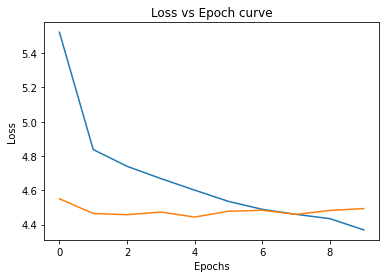

In [ ]:
train_test_metrics_graph(train_loss_all, val_loss_all)